When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
%matplotlib inline

## Wikipedia Movie Plots

Link: https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots/data

## Load Wikipedia dataset

In [3]:
wiki = pd.read_csv('wiki_movie_plots_deduped.csv')
wiki.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


If you want to check whether the text on the webpage agrees with the one here, you can display it with the following code:

The dataset contains several parameters which describe the movie
The parameters included are :

- `Release Year` 
- `Title` 
- `Origin/Ethnicity` 
- `Director` 
- `Cast` 
- `Wiki Page` 
- `Plot` 

In [4]:
print(wiki.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB
None


**Notes:** As we can observe in info we can see that there are 0 null values, but actually, looking at the head we can notice that some of the columns can have null values but it is written "Unknown" or "NaN". I have decided not to delete any column or row, because it can damage the results(sometimes there can be no genre written in, but the plot will be informative and can be useful to indicate if it is close to the chosen article)

In [5]:
wiki.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


**Notes:** There we can only analize the year of release. We can notice that there are 34886 films in the dataset. The timestamp of this film releases is 1901 to 2017.

## Ex. 1: Extract word count vectors

As we have seen in Assignment 4, we can extract word count vectors using `CountVectorizer` function.
- make sure you include words of unit length by using the parameter: `token_pattern=r"(?u)\b\w+\b"`
- do not use any stopwords
- take 10000 most frequent words in the corpus
- explicitly take all the words independent of in how many documents they occur
- obtain the matrix of word counts

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b", max_features=10000)
WCmatrix = vectorizer.fit_transform(wiki["Plot"])

WCmatrix


<34886x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 5759797 stored elements in Compressed Sparse Row format>

## Ex. 2: Find nearest neighbors

**a)** Start by finding the nearest neighbors of the Star Wars: Episode I – The Phantom Menace page using the above word count matrix to represent the articles and **Euclidean** distance to measure distance.
Save the distances in `wiki['SW1-eucl']` and look at the top 10 nearest neighbors.

In [7]:
# One can use the following:
    # from sklearn.neighbors import NearestNeighbors
    # nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute',metric='euclidean').fit(X.toarray())
    # distances, indices = nbrs.kneighbors(X.toarray())
# but here let's use:
from sklearn.metrics import pairwise_distances

bo_vector = WCmatrix[wiki[wiki["Title"] == "Star Wars: Episode I – The Phantom Menace"].index[0]]
dist = pairwise_distances(bo_vector.reshape(1, -1), WCmatrix, metric='euclidean')
wiki["SW1-eucl"] = dist.flatten()
wiki.sort_values(by='SW1-eucl').iloc[:10]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,SW1-eucl
13553,1999,Star Wars: Episode I – The Phantom Menace,American,George Lucas,"Liam Neeson, Ewan McGregor, Natalie Portman, J...",space opera,https://en.wikipedia.org/wiki/Star_Wars:_Episo...,The Trade Federation upsets order in the Galac...,0.000000
16378,2012,Star Wars: Episode I – The Phantom Menace 3D,American,George Lucas,"Liam Neeson, Ewan McGregor, Jake Lloyd, Ahmed ...",sci-fi,https://en.wikipedia.org/wiki/Star_Wars:_Episo...,The Trade Federation upsets order in the Galac...,0.000000
7668,1962,Taras Bulba,American,J. Lee Thompson,"Yul Brynner, Tony Curtis, Sam Wanamaker, Chris...",adventure,https://en.wikipedia.org/wiki/Taras_Bulba_(196...,"The film opens in the 16th century, when Russi...",34.785054
14765,2005,Star Wars: Episode III – Revenge of the Sith,American,George Lucas,"Ewan McGregor, Hayden Christensen, Natalie Por...","science fiction, action",https://en.wikipedia.org/wiki/Star_Wars:_Episo...,"Three years after the Battle of Geonosis, the ...",35.142567
32931,1966,Daimajin,Japanese,"Yasuda, KimiyoshiKimiyoshi Yasuda","Miwa Takada, Yoshihiko Aoyama, Jun Fujimaki",unknown,https://en.wikipedia.org/wiki/Daimajin_(1966_f...,The movie opens with a household of peasants c...,36.097091
33207,1993,Ninja Scroll,Japanese,Yoshiaki Kawajiri,"Kōichi Yamadera, Emi Shinohara",anime,https://en.wikipedia.org/wiki/Ninja_Scroll,"In Edo period-Japan, the Yamashiro clan mines ...",37.040518
15482,2008,Meet the Spartans,American,"Jason Friedberg, Aaron Seltzer","Sean Maguire, Ken Davitian, Carmen Electra, Di...",comedy,https://en.wikipedia.org/wiki/Meet_the_Spartans,The film opens with a Spartan elder inspecting...,37.094474
7446,1961,"Atlantis, the Lost Continent",American,George Pal,"John Dall, Edward Platt",sci-fi,"https://en.wikipedia.org/wiki/Atlantis,_the_Lo...",A Greek fisherman named Demetrios and his fath...,37.094474
9212,1975,The Wind and the Lion,American,John Milius,"Sean Connery, Candice Bergen, John Huston, Geo...",adventure,https://en.wikipedia.org/wiki/The_Wind_and_the...,"During 1904, Morocco is the source of conflict...",37.134889
13095,1997,The Peacemaker,American,Mimi Leder,"George Clooney, Nicole Kidman",action,https://en.wikipedia.org/wiki/The_Peacemaker_(...,"In an Eastern Orthodox church in Pale, Bosnia ...",37.229021


**Note:** Looking at the reult we can observe that some of the results dont't make sense. There is no closeness between Star Wars 1 and Taras Bulba, but recording to the results it is the closest neighour. We can't take into consideration 3D version of the Star Wars 1, because it is the same movie.


The `pairwise_distances` function in sklearn computes the distance matrix from a vector array, such as `bo_vector` and `WCmatrix`. By using this function, I calculated the Euclidean distances between Star Wars 1 and other articles. The calculated distances were then saved in the `SW1-eucl` column, and the 10 nearest neighbors were printed out

Apply K-Means clustering and explore articles within the same cluster as your selected article.

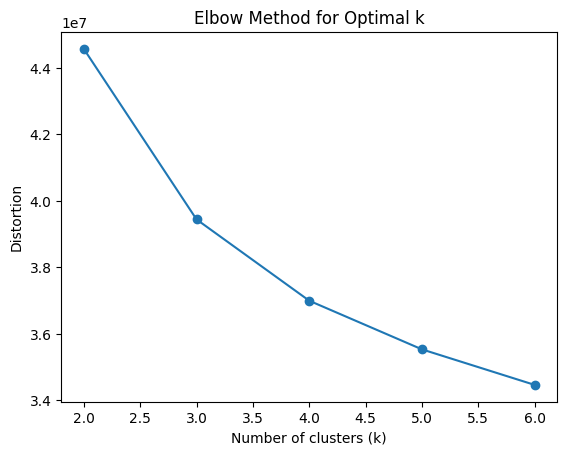

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(WCmatrix)
cluster_id = clusters[wiki[wiki["Title"] == "Star Wars: Episode I – The Phantom Menace"].index[0]]

similar_articles_cluster = wiki[clusters == cluster_id]

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
k_values = [2, 3, 4, 5, 6]

distortions = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(WCmatrix)
    distortions.append(kmeans.inertia_)

plt.plot(k_values, distortions, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.show()



**Notes:** The Elbow Method is a technique used to find the optimal number of clusters (`k`) in a KMeans clustering algorithm. The basic idea: to run the KMeans algorithm for a range of values of `k` and plot the sum of squared distances (also known as distortion) from each point to its assigned cluster center. The "elbow" of the plot is the point where the rate of decrease in distortion slows down, suggesting that increasing the number of clusters beyond that point doesn't significantly improve the model.

Here's how the process works:

1. Fit the KMeans model for different values of `k`.
2. For each `k`, calculate the sum of squared distances (distortion) of samples to their closest cluster center.
3. Plot the distortion for each `k`.
4. Identify the "elbow" in the plot, which is the point where the rate of decrease in distortion slows down.

The optimal number of clusters is often chosen as the value of `k` at the elbow, as it represents a balance between minimizing distortion and avoiding overfitting.

In the Elbow Method plot:

- As `k` increases, the distortion tends to decrease because each point is closer to its cluster center.
- However, there is a point where the improvement in distortion becomes marginal, and the plot forms an "elbow" shape.
- The elbow represents a trade-off between having enough clusters to capture the data's structure and avoiding too many clusters, which may lead to overfitting.

It's important to note that the Elbow Method is a heuristic, and in some cases, the "elbow" may not be clearly defined. In such cases, additional techniques or domain knowledge may be needed to determine the optimal number of clusters.

**Notes:** I must say that it is very time consuming if the values in k_values array are higher than 6.

**b)** Measure the pairwise distance between the Wikipedia pages of Star Wars: Episode I – The Phantom Menace, Star Wars: Episode II – Attack of the Clones, and Return of the Jedi. 

In [115]:
distance = pairwise_distances(WCmatrix[wiki[wiki["Title"].isin(["Star Wars: Episode I – The Phantom Menace", "Star Wars: Episode II – Attack of the Clones", "Return of the Jedi"])].index])

# Check if there are at least two rows in the distance array
if distance.shape[0] >= 2:
    print(f"Star Wars: Episode I – The Phantom Menace and Star Wars: Episode II – Attack of the Clones distance: {distance[1, 0]}")
    print(f"Star Wars: Episode I – The Phantom Menace and Return of the Jedi distance: {distance[1, 2]}")
    print(f"Return of the Jedi and Star Wars: Episode II – Attack of the Clones distance: {distance[0, 2]}")
else:
    print("Not enough rows in the distance array.")



Star Wars: Episode I – The Phantom Menace and Star Wars: Episode II – Attack of the Clones distance: 47.66550115125194
Star Wars: Episode I – The Phantom Menace and Return of the Jedi distance: 39.395431207184416
Return of the Jedi and Star Wars: Episode II – Attack of the Clones distance: 52.744667976962376


**Notes:** I have created a vector to save the distances values named `distance`. And with the help of `pairwise_distance` I have calculated the distances.

**c)** Let's find out if Dune is close to Star Wars 1. While searching for close films to Star Wars 1 I found out that all of them included Dune.
To do this, look at the most frequently used words in each of Star Wars 1 and Dune's pages.

In [116]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
 
    df = pd.DataFrame(wiki[wiki["Title"] == name]["Plot"].values[0].split(), columns=["word"])
    count = df["word"].value_counts().to_frame("count")
    return count.sort_values(by='count',ascending=False)

**Notes:** In the provided code, I filtered the dataset to obtain the specified person's data, split the text into words, and created a dataset. Subsequently, I used the `value_count` function to count the occurrences of each word. Afterward, I sorted the dataframe by count in descending order.

In [117]:
star_wars1_words = top_words('Star Wars: Episode I – The Phantom Menace')
star_wars1_words

,count
the,50
to,33
and,25
a,19
of,13
...,...
them,1
queen,1
joining,1
pushing,1


In [118]:
dune_words = top_words('Dune')
dune_words

,count
the,69
to,35
and,25
a,21
of,21
...,...
fall,1
first,1
time,1
"ever,",1


**d)** Extract the list of most frequent **common** words that appear in both Star Wars 1 and Dune documents and display the five words that appear most often in Dune's article.

Use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the index column of words). See [the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) for more details.

In [119]:
# Modify the code to avoid error.
star_wars1_words.join(dune_words, lsuffix="_Star_Wars1", rsuffix="_Dune", how="inner").head(5)

,count_Star_Wars1,count_Dune
the,50,69
to,33,35
and,25,25
a,19,21
of,13,21


**Notes:** Here, it's evident that the most frequently used words include articles and pronouns, which are typically common in the general context of writing articles. We can insist that this films have some common features and simularities in plot, while actually watching the films, but it is hard to tell that these films have something common while simply analizing them by plot.

Collect all words that appear both in Star Wars 1 and Star Wars 2 pages.  Out of those words, find the 10 words that show up most often in Star Wars 1 page. 

In [120]:
star_wars2_words = top_words('Star Wars: Episode II – Attack of the Clones')
star_wars1_words.join(star_wars2_words, lsuffix="_Star_Wars1", rsuffix="_Star_Wars2", how="inner").head(10)

,count_Star_Wars1,count_Star_Wars2
the,50,26
to,33,25
and,25,22
a,19,12
of,13,8
in,11,4
as,10,2
is,9,11
Jedi,9,8
Anakin,9,11


**Note:** But here we can actually see, that films have some common features according to the plot. As we can See, appart from the general articles(the, to, and) and ecs. we can observe that words such as Jedi and Anakin are frequently used in both films' articles. These words are very specific. I doubht that Taras Bulba or Daimajin, which were considered close to Star ars 1 at the beginning will have such words in the plot or their article.

**e)** Among the words that appear in both Star Wars 1 and Dune, take the 15 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [121]:

word_to_ind = {v: i for i, v in enumerate(vectorizer.get_feature_names_out())}


common_words_df = star_wars1_words.join(dune_words, rsuffix="_Dune").dropna()

top_common_words = common_words_df.sort_values(by="count", ascending=False).iloc[:15].index

articles = [i for i, article in enumerate(WCmatrix) if all(article[:, word_to_ind[word]].todense().all() for word in top_common_words)]

print("Number of articles containing all top common words:", len(articles))

Number of articles containing all top common words: 13118


**Notes:** Utilizing the `dropna` function, I removed all the missing values in the dataframe named `common_words_df`, which is generated by combining the word count information from both Star Wars 1 and Dune articles. Then I select 15 most common words, get the indices of articles where all these most common words appear and print out the count of articles containing all top common words.

**Notes:** And here we can observe that there are a lot of articles that contain these common words, because Dune and Star Wars 1 don't have any simularities according to the plot and their common words are very basic.

In [122]:
wiki['Title'][articles]

8                        The Little Train Robbery
21                          The Fight for Freedom
33                                         Ramona
34                            What the Daisy Said
37       The Black Arrow: A Tale of the Two Roses
                           ...                   
34875                Once Upon a Time in Anatolia
34876                                       Selam
34879                                Winter Sleep
34881                           The Water Diviner
34884                            Non-Transferable
Name: Title, Length: 13118, dtype: object

## Ex. 3: TF-IDF to the rescue

**a)** Repeat the search for the 10 nearest neighbors of Star Wars 1 with Euclidean distance of TF-IDF. This time do not limit to only 10000 most frequent words, but take all of them.

In [123]:
# We could use:
    # from sklearn.feature_extraction.text import TfidfVectorizer
# but since we already know how to compute CountVectorizer, let's use:
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
WCmatrix=vectorizer.fit_transform(wiki["Plot"])

tfidf=TfidfTransformer(smooth_idf=False, norm=None)
TFIDFmatrix = tfidf.fit_transform(WCmatrix)

**Notes:** In this exercise, we are performing something very similar to what we did at the beginning of the assignment, but now we are using the `TfidfTransformer`. This function transforms a count matrix into a normalized term frequency (tf) or term frequency-inverse document frequency (tf-idf) representation. The smoothing of idf weights is achieved by adding one to document frequencies, as if an extra document were seen containing every term in the collection exactly once. The parameter `norm=None` indicates that we are keeping the raw term frequencies without normalization.

In [124]:
# now recompute the distances as before but for TF-IDF
dist = pairwise_distances(TFIDFmatrix[wiki[wiki["Title"] == "Star Wars: Episode I – The Phantom Menace"].index], TFIDFmatrix)

wiki['SW1-eucl-TF-IDF'] = dist[0]
wiki[['Title', 'SW1-eucl-TF-IDF']].sort_values(by='SW1-eucl-TF-IDF').iloc[:10]

,Title,SW1-eucl-TF-IDF
13553,Star Wars: Episode I – The Phantom Menace,0.000000
16378,Star Wars: Episode I – The Phantom Menace 3D,0.000000
14155,Star Wars: Episode II – Attack of the Clones,302.015440
34659,No Tears for the Dead,348.948891
34613,Tough as Iron,356.195910
28317,Puthiya Theerangal (പുതിയ തീരങ്ങൾ),359.514513
29049,Manithan,359.514898
21801,Siege,359.632726
5138,House by the River,359.692031
31189,Onaayum Aattukkuttiyum,359.704100


**Notes:** It's notable that the 10 nearest neighbors of Star Wars 1, calculated using Euclidean distance after applying TF-IDF, are entirely different and make more sense compared to the results obtained without TF-IDF.

**Notes:** Looking at the results I had to understand why No Tears for the Dead is considered close to Star Wars 1. Searching a Wikipedia I found a plot of this film. No Tears for the Dead is a 2014 South Korean action film written and directed by Lee Jeong-beom. The film revolves around a professional hitman who is conflicted about killing his last target. 


So I understood by reading this plot, that now the result makes much more sense.

**b)** Sort the words in Star Wars 1 article by their TF-IDF weights; do the same for No Tears for the Dead article as well.
Using the **join** operation we learned earlier, compute the common words shared by Star Wars 1 and No Tears for the Dead articles.
Sort the common words by their TF-IDF weights in Star Wars 1 document.

In [125]:
def top_words_tf_idf(name):
    """
    Get a table of the largest tf-idf words in the given person's Wikipedia page.
    """
    words = wiki[wiki['Title'] == name]['Plot'].values[0].split()
    ind = {v: i for i, v in enumerate(vectorizer.get_feature_names_out())}
    words_weights = [TFIDFmatrix[wiki[wiki['Title'] == name].index][0, ind.get(word, -1)] for word in words]
    
    words_weights = [weight for weight in words_weights if weight != -1]
    
    df = pd.Series(words_weights, words).to_frame("tf-idf")
    df.drop_duplicates(inplace=True)
    return df.sort_values(by='tf-idf', ascending=False)




**Notes:** The `top_words_tf_idf` function simplifies the process of extracting and displaying words with the highest TF-IDF values from a given person's wiki page. It leverages scikit-learn's `TfidfTransformer` to calculate TF-IDF weights for each word, and then returns a table sorted by TF-IDF values in descending order. This function is useful for identifying the most distinctive and significant words associated with a particular individual within a broader text corpus.

In [126]:
star_wars1_tf_idf = top_words_tf_idf('Star Wars: Episode I – The Phantom Menace')
star_wars2_tf_idf = top_words_tf_idf('Star Wars: Episode II – Attack of the Clones')

star_wars1_tf_idf.join(star_wars2_tf_idf, rsuffix="_Star_wars2", lsuffix="_Star_Wars1", how="inner").head(15)

,tf-idf_Star_Wars1,tf-idf_Star_wars2
droid,63.433619,27.185837
the,55.412983,30.784991
to,34.587003,26.202275
and,26.193253,23.050063
planet,21.678345,10.839172
a,20.506856,12.304114
battle,19.324782,19.324782
invasion,17.169806,5.723269
as,14.876319,5.409570
of,13.979121,8.602536


**c)** Among the words that appear in both Star Wars 1 and No Tears for the Dead, take the 15 that have largest weights in Star Wars 1. How many of the articles in the Wikipedia dataset contain all of those 15 words? 

In [127]:
# It might be helpful to use:
word_to_ind = {v: i for i, v in
               enumerate(vectorizer.get_feature_names_out())}  # a dictionary with words as keys and indices as values

star_wars_common = star_wars1_tf_idf.join(star_wars2_tf_idf, rsuffix="_Star_Wars2", lsuffix="_Star_Wars1", how="inner").iloc[:15]

articles = WCmatrix[:, [word_to_ind[word] for word in star_wars_common.index]]
articles = [i for i, article in enumerate(articles) if article.todense().all()]
print(len(articles))


3


In [128]:
wiki['Title'][articles]

13553       Star Wars: Episode I – The Phantom Menace
14155    Star Wars: Episode II – Attack of the Clones
16378    Star Wars: Episode I – The Phantom Menace 3D
Name: Title, dtype: object

Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Ex. 4: Choosing metrics

**a)** Compute the Euclidean distance between TF-IDF features of Star Wars 1 and Return of the Jedi.

In [129]:
dist = pairwise_distances(TFIDFmatrix[wiki[(wiki['Title'] == "Star Wars: Episode I – The Phantom Menace") | (wiki['Title'] == "Return of the Jedi")].index])
print("Star Wars 1 and Return of the Jedi distance:", dist[0, 1])

Star Wars 1 and Return of the Jedi distance: 424.09120035194485


**Notes:** I have calculated the pairwise distances between the TF-IDF vectors of Sttar Wars 1 and Return of the Jedi using the `pairwise_distances` function from `sklearn.metrics`. The distances are stored in the variable `dist`. The distance is then accessed using `dist[0, 1]` since they are the first and second elements in the selected rows.

The distance is larger than the distances we found for the 10 nearest neighbors, which we repeat here for readability:

In [130]:
wiki.sort_values(by='SW1-eucl-TF-IDF',ascending=True)[['Title','SW1-eucl-TF-IDF']][0:10]

,Title,SW1-eucl-TF-IDF
13553,Star Wars: Episode I – The Phantom Menace,0.000000
16378,Star Wars: Episode I – The Phantom Menace 3D,0.000000
14155,Star Wars: Episode II – Attack of the Clones,302.015440
34659,No Tears for the Dead,348.948891
34613,Tough as Iron,356.195910
28317,Puthiya Theerangal (പുതിയ തീരങ്ങൾ),359.514513
29049,Manithan,359.514898
21801,Siege,359.632726
5138,House by the River,359.692031
31189,Onaayum Aattukkuttiyum,359.704100


**b)** Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Star Wars 1 page. To compute text length use the same splitting rules you used in `vectorizer`.

In [131]:
tokenizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
WCmatrix = vectorizer.fit_transform(wiki["Plot"])


tokenizer = vectorizer.build_tokenizer()

def compute_length(row):
# Here we could use simply:
#     return len(row['text'].split(' '))
    return len(tokenizer(row['Plot']))

wiki['length'] = wiki['Plot'].apply(lambda x: len(tokenizer(x)))

**Notes:** I have created a `CountVectorizer` named `vectorizer` with the specified `token_pattern`. Then, I used this vectorizer to fit and transform the "text" column of the wiki ddf, obtaining the word count matrix (`WCmatrix`).


Afterwards, I have created a custom tokenizer by calling `build_tokenizer()` on the `vectorizer`. This custom tokenizer is assigned to the variable `tokenizer`.

Finally, I define a function `compute_length` that takes a row of the wiki df, extracts the text column from that row, and applies the custom tokenizer to calculate the length of the tokenized text. The result is stored in a new column named length in the wiki df using the `apply` function.

In [132]:
nearest_neighbors_euclidean = wiki.sort_values(by='SW1-eucl-TF-IDF',ascending=True)[['Title','length', 'SW1-eucl-TF-IDF']][0:100]
nearest_neighbors_euclidean

,Title,length,SW1-eucl-TF-IDF
13553,Star Wars: Episode I – The Phantom Menace,699,0.000000
16378,Star Wars: Episode I – The Phantom Menace 3D,699,0.000000
14155,Star Wars: Episode II – Attack of the Clones,527,302.015440
34659,No Tears for the Dead,205,348.948891
34613,Tough as Iron,189,356.195910
...,...,...,...
18846,The Weaker Sex,96,360.439189
29306,Ratha Thilagam,42,360.441760
27303,Magic Ajji,120,360.441902
5512,Submarine Command,91,360.442082


**Notes:** The code finds the 100 nearest neighbors to Star Wars 1 based on Euclidean distance using TF-IDF representation and creates a dataframe `nearest_neighbors_euclidean` with columns for name, length, and distance.

**c)** To see how these document lengths compare to the lengths of other documents in the corpus, make a histogram of the document lengths of Star Wars 1 100 nearest neighbors and compare to a histogram of document lengths for all documents.

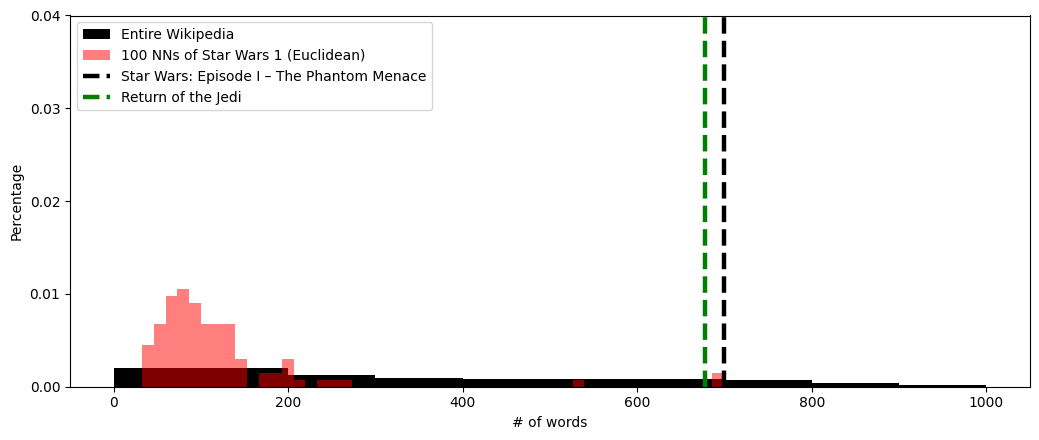

In [66]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki.length, range=[0, 1000], density=True, color='black', label='Entire Wikipedia')
plt.hist(nearest_neighbors_euclidean.length, bins=50, alpha=0.5, density=True, color='red', label='100 NNs of Star Wars 1 (Euclidean)')
plt.axvline(wiki[wiki["Title"] == "Star Wars: Episode I – The Phantom Menace"].length.values[0], label='Star Wars: Episode I – The Phantom Menace', color='black', linestyle='--', linewidth=3.2)
plt.axvline(wiki[wiki["Title"] == "Return of the Jedi"].length.values[0], label='Return of the Jedi', color='green', linestyle='--', linewidth=3.2)

plt.xlabel("# of words")
plt.ylabel("Percentage")
plt.yticks(np.arange(0.00, 0.040001, 0.01))
plt.legend()
plt.tight_layout()


**Notes:** I used Matplotlib to create a histogram comparing the document lengths of the entire Wikipedia corpus, the 100 nearest neighbors to Star Wars 1 based on Euclidean distance, and specific lengths for Star Wars 1 and Return of the Jedi. It visualizes the distribution of document lengths, highlighting the positions of Star Wars 1 and Return of the Jedi in the histogram. The vertical dashed lines represent the lengths of Star Wars 1 and Return of the Jedi documents, and the histograms provide insights into the word count distribution across the different datasets.

**Notes** Relative to the rest of Wikipedia, nearest neighbors of Star Wars 1 are overwhemingly short, most of them being shorter than 200 words. The bias towards short articles is not appropriate in this application as there is really no reason to favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 400 words or more, and both Star Wars 1 and Return of the Jedi are over 600 words long.


**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

**d)** Train a new nearest neighbor model, this time with cosine distances.  Then repeat the search for Star Wars 1 100 nearest neighbors and make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

In [60]:

dist_cosine = pairwise_distances(TFIDFmatrix[wiki[wiki["Title"] == 'Star Wars: Episode I – The Phantom Menace'].index],TFIDFmatrix, metric="cosine")
wiki["SW1-cosine-TF-IDF"] = dist_cosine.T
nearest_neighbors_cosine = wiki.sort_values(by='SW1-cosine-TF-IDF', ascending=True)[['Title', 'length', 'SW1-cosine-TF-IDF']][:100]


nearest_neighbors_cosine

,Title,length,SW1-cosine-TF-IDF
13553,Star Wars: Episode I – The Phantom Menace,699,0.000000
16378,Star Wars: Episode I – The Phantom Menace 3D,699,0.000000
14155,Star Wars: Episode II – Attack of the Clones,527,0.429094
14765,Star Wars: Episode III – Revenge of the Sith,615,0.552560
15534,Star Wars: The Clone Wars,502,0.596957
...,...,...,...
14848,The Breed,849,0.882990
26397,Rang De Basanti,965,0.883118
11012,Miracle Mile,738,0.883336
26437,Dus Kahaniyaan,1783,0.883343


From a glance at the above table, things look better.  For example, we now see Return of the Jedi as Star Wars 1 nearest neighbor

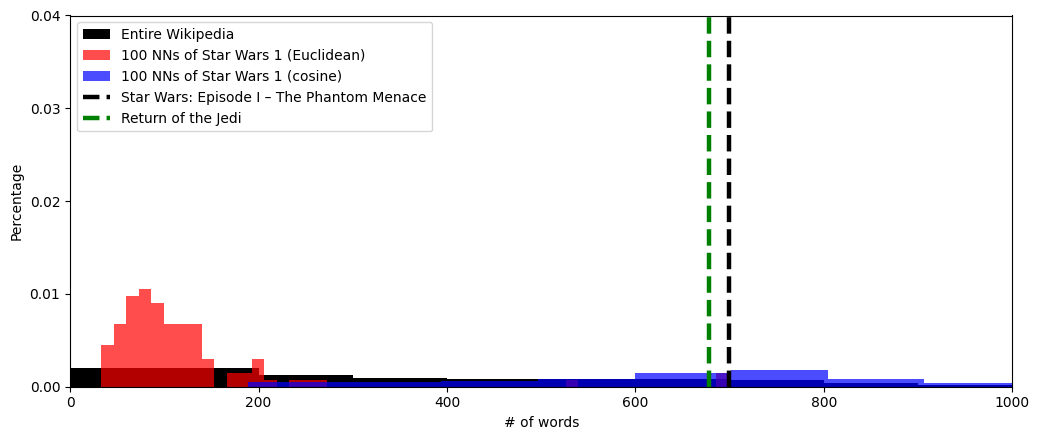

In [61]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki.length, range=[0, 1000], density=True, color='black', label='Entire Wikipedia')
plt.hist(nearest_neighbors_euclidean.length, bins=50, alpha=0.7, density=True, color='red', label='100 NNs of Star Wars 1 (Euclidean)')
plt.hist(nearest_neighbors_cosine.length, bins=50, alpha=0.7, density=True, color='blue', label='100 NNs of Star Wars 1 (cosine)')
plt.axvline(wiki[wiki["Title"] == "Star Wars: Episode I – The Phantom Menace"].length.values[0], label='Star Wars: Episode I – The Phantom Menace', color='black', linestyle='--', linewidth=3.2)
plt.axvline(wiki[wiki["Title"] == "Return of the Jedi"].length.values[0], label='Return of the Jedi', color='green', linestyle='--', linewidth=3.2)

plt.xlabel("# of words")
plt.ylabel("Percentage")
plt.yticks(np.arange(0.00, 0.040001, 0.01))
plt.xlim([0, 1000])
plt.legend()
plt.tight_layout()

**Notes:** I used Matplotlib to create a histogram comparing the document lengths of the entire Wikipedia corpus, the 100 nearest neighbors to Star Wars 1 based on Euclidean distance, and the 100 nearest neighbors based on cosine similarity. It visualizes the distribution of document lengths for these datasets, highlighting the positions of Star Wars 1 and Return of the Jedi with vertical dashed lines. The histograms provide insights into the word count distribution across different distance metrics, allowing for a comparison of document length distributions.

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

## Ex. 5: Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

**a)** Transform the tweet into TF-IDF features, using the fit to the Wikipedia dataset. (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.) How similar is this tweet to Star Wars 1 Wikipedia article? 

In [62]:
df = pd.DataFrame({'Plot': ["star wars is space opera franchise the saga explores the galaxy where the jedi and sith engage in epic battles"]})

tfidfd = tfidf.transform(vectorizer.transform(df["Plot"]))

def top_words_tf_idf(df):
    words = df['Plot'].values[0].split()
    ind = {v : i for i, v in enumerate(vectorizer.get_feature_names_out())}
    words_weigths = [tfidfd[0, ind[word]] for word in words]
    words_count = [words.count(word) for word in words]
    data = {"count" : words_count, "tf_idf" : words_weigths}
    df = pd.DataFrame(data, index=words)
    return df
top_words_tf_idf(df)

,count,tf_idf
star,1,4.144622
wars,1,6.768493
is,1,1.100607
space,1,4.955553
opera,1,5.922507
franchise,1,7.722171
the,3,3.078499
saga,1,7.933480
explores,1,6.341847
the,3,3.078499


Let's compare this tweet's TF-IDF vectors  to Star Wars 1 Wikipedia entry.

In [63]:
star_wars1_tf_idf

,tf-idf
droid,63.433619
the,55.412983
to,34.587003
starship,33.127148
chancellor,31.083846
...,...
which,1.888545
them,1.814024
up,1.718696
has,1.480968


**b)** Now, compute the cosine distance between the Star Wars 1 article and this tweet:

In [64]:
from sklearn.metrics.pairwise import cosine_distances # for one pair of samples we can just use this function

# Your code goes here
cosine_distances(TFIDFmatrix[wiki[wiki["Title"] == "Star Wars: Episode I – The Phantom Menace"].index], tfidfd)

array([[0.85966996]])

Let's compare this distance to the distance between the Star Wars 1 article and all of its Wikipedia nearest neighbors:

In [65]:
nearest_neighbors_cosine[0:23]

,Title,length,SW1-cosine-TF-IDF
13553,Star Wars: Episode I – The Phantom Menace,699,0.000000
16378,Star Wars: Episode I – The Phantom Menace 3D,699,0.000000
14155,Star Wars: Episode II – Attack of the Clones,527,0.429094
14765,Star Wars: Episode III – Revenge of the Sith,615,0.552560
15534,Star Wars: The Clone Wars,502,0.596957
9428,Star Wars Episode IV: A New Hope (aka Star Wars),666,0.698967
34659,No Tears for the Dead,205,0.735262
34716,The Shameless,237,0.803706
33750,Hunter × Hunter: The Last Mission,583,0.816948
34613,Tough as Iron,189,0.820467


**Notes:** At the end, we check the cosine distance of the tweet from Star Wars 1 and its closest neighbours.These words are strongly correlated with the star wars theme. And we can see that a lot of the titles here are actually close to Star Wars 1.